# 태양광
***
### 3년(Day 0 ~ Day 1094) 동안의 기상 데이터, 발전량(TARGET) 데이터

### test는 2년동안의 기상데이터, 발전량(TARGET) 데이터

### 각 파일의 7일 동안의 데이터 전체 혹은 일부 활용하여 향후 2일 동안의 30분 간격 발전량 예측
****
- Hour - 시간
- Minute - 분
- DHI - 수평면 산란일사량(Diffuse Horizontal Irradiance (W/m2))
- DNI - 직달일사량(Direct Normal Irradiance (W/m2))
- WS - 풍속(Wind Speed (m/s))
- RH - 상대습도(Relative Humidity (%))
- T - 기온(Temperature (Degree C))
- Target - 태양광 발전량 (kW)
***

## 1. Package Import

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import itertools
import time

import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg as qreg
import statsmodels.formula.api as smf

from tqdm import tnrange, tqdm_notebook

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import *
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import os
from lightgbm import LGBMRegressor
import datetime
#from skgarden import RandomForestQuantileRegressor, DecisionTreeQuantileRegressor, ExtraTreeQuantileRegressor, ExtraTreesQuantileRegressor

***
## 2. Load Data

In [160]:
train = pd.read_csv('/Users/kisehyun/DACON/SUN/train/train.csv')

In [161]:
for i in range(81) :
    globals() [f'test_{i}'] = pd.read_csv(f'/Users/kisehyun/DACON/SUN/test/{i}.csv')
    globals() [f'test_{i}']['sep_day'] = i

In [162]:
### 각 데이터를 하나의 데이터로 통합
test = pd.DataFrame()
idx_list = []
for i in range(81):
    test = pd.concat([test, globals()[f'test_{i}']], axis = 0, ignore_index = True)

In [163]:
submission = pd.read_csv('sample_submission.csv')

In [164]:
train.head()

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0,0,0,0,0,1.5,69.08,-12,0.0
1,0,0,30,0,0,1.5,69.06,-12,0.0
2,0,1,0,0,0,1.6,71.78,-12,0.0
3,0,1,30,0,0,1.6,71.75,-12,0.0
4,0,2,0,0,0,1.6,75.20,-12,0.0


In [165]:
test.head()

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,sep_day
0,0,0,0,0,0,2.7,34.42,0.0,0.0,0
1,0,0,30,0,0,2.7,34.17,0.1,0.0,0
2,0,1,0,0,0,2.7,34.23,0.2,0.0,0
3,0,1,30,0,0,2.7,33.99,0.3,0.0,0
4,0,2,0,0,0,2.8,33.97,0.4,0.0,0


***
## 3. Make Features

<br>
<br>

일조시간 변수 생성


In [166]:
tr_times = []
for day in train.Day.unique() :
    d = train.loc[train.Day == day]
    try :
        start = d.loc[d.DNI > 0].index[0]
        end = d.loc[d.DNI > 0].index[-1]
        gap = (end - start) / 2
    except :
        gap = 0

    tr_times.append(gap)

In [167]:
test['sep'] = test.index // 48
te_times = []
for day in test.sep.unique() :
    d = test.loc[test.sep == day]
    try :
        start = d.loc[d.DNI > 0].index[0]
        end = d.loc[d.DNI > 0].index[-1]
        gap = (end - start) / 2
    except :
        gap = 0

    te_times.append(gap)

In [168]:
train_sun_time = pd.DataFrame({'Day' : train.Day.unique(), 'sun_time' : tr_times})
test_sun_time = pd.DataFrame({'sep' : test.sep.unique(), 'sun_time' : te_times})

In [169]:
train = pd.merge(train, train_sun_time, how = 'left', on = 'Day')
test = pd.merge(test, test_sun_time, how = 'left', on = 'sep').drop('sep', axis = 1)

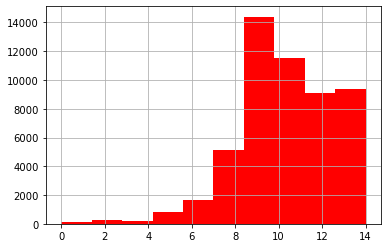

In [170]:
train.sun_time.hist(color = 'red')
plt.show()

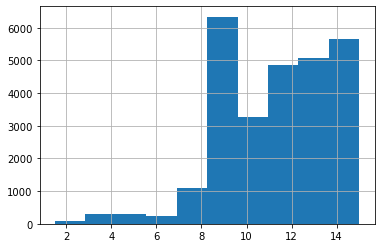

In [171]:
test.sun_time.hist()
plt.show()

계절 변수 생성(온도를 기준으로)

In [172]:
def season(x) :
    if x < 5 :
        return 0
    elif 5 <= x < 24 :
        return 1
    else :
        return 2

In [173]:
train_temp_mean = train.groupby('Day')['T'].mean().reset_index(name = 'temp_mean')
train_temp_mean['season'] = train_temp_mean['temp_mean'].apply(season)

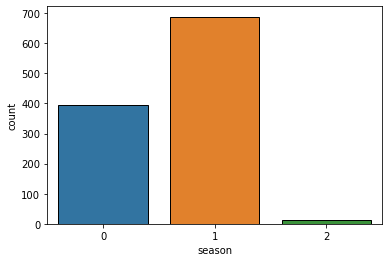

In [174]:
sns.countplot(train_temp_mean.season, edgecolor = (0,0,0))
plt.show()

In [175]:
#train = pd.merge(train, train_temp_mean, how = 'left', on = 'Day')

In [176]:
test_temp_mean = test.groupby('sep_day')['T'].mean().reset_index(name = 'temp_mean')
test_temp_mean['season'] = test_temp_mean['temp_mean'].apply(season)

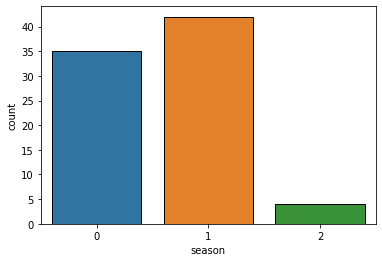

In [177]:
sns.countplot(test_temp_mean.season, edgecolor = (0,0,0))
plt.show()

In [178]:
#test = pd.merge(test, test_temp_mean, how = 'left', on = 'sep_day')

In [179]:
#train.groupby('season').TARGET.mean().plot(kind = 'bar')
#plt.show()

In [180]:
#test.groupby('season').TARGET.mean().plot(kind = 'bar')
#plt.show()

In [181]:
#train.season = train.season.map({'summer' : 2, 'spring_or_fall' : 1, 'winter' : 0})
#test.season = test.season.map({'summer' : 2, 'spring_or_fall' : 1, 'winter' : 0})

train['season'] = train['T'].apply(season)
test['season'] = test['T'].apply(season)

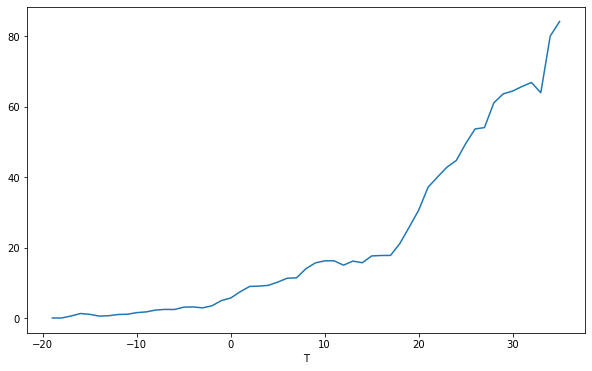

In [182]:
plt.figure(figsize = (10, 6))
train.groupby('T').TARGET.mean().plot()
plt.show()

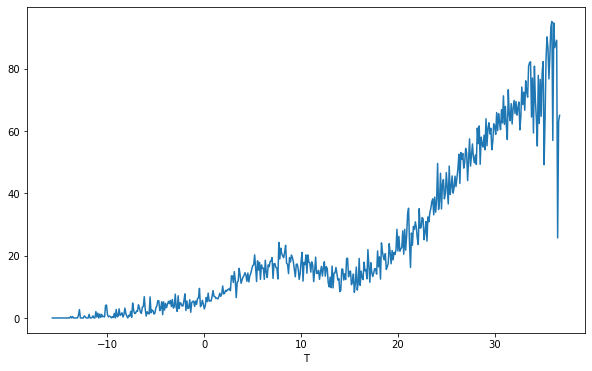

In [183]:
plt.figure(figsize = (10, 6))
test.groupby('T').TARGET.mean().plot()
plt.show()

In [184]:
def eff_gap(x) :
  if 0 < x < 25 :
    return (25 - x) * 0.5
  elif x == 25 :
    return 0
  else :
    return (25 - x) * .05

In [185]:
#train['eff_gap'] = train['T'].apply(eff_gap)
#test['eff_gap'] = test['T'].apply(eff_gap)

In [186]:
train['DNI'] = np.log1p(train['DNI'])
train['DHI'] = np.log1p(train['DHI'])
train['WS'] = np.log1p(train['WS'])

In [187]:
test['DNI'] = np.log1p(test['DNI'])
test['DHI'] = np.log1p(test['DHI'])
test['WS'] = np.log1p(test['WS'])

In [188]:
train.Minute = train.Minute.map({30 : 1, 0: 0})
test.Minute = test.Minute.map({30 : 1, 0: 0})

In [189]:
train['hour_mean'] = train.Hour.map(train.groupby('Hour').TARGET.mean())
test['hour_mean'] = test.Hour.map(test.groupby('Hour').TARGET.mean())

In [190]:
#train['day_mean'] = train.Day.map(train.groupby('Day').TARGET.mean())
#test['day_mean'] = test.Day.map(test.groupby('Day').TARGET.mean())

In [191]:
train_after_2 = train.loc[train.Day <= 1092]
train_after_2['TARGET2'] = list(train.loc[train.Day >= 2].TARGET)
train_after_2['Day'] = train_after_2.Day % 9

In [192]:
train_after_2.drop(['Day', 'Minute'], axis =1 ,inplace = True)
test.drop('sep_day', axis = 1, inplace = True)

In [193]:
actual1 = test.query('Day in [2,3]').TARGET
actual2 = test.query('Day in [3,4]').TARGET
actual3 = test.query('Day in [4,5]').TARGET
actual4 = test.query('Day in [5,6]').TARGET

actual_list = [actual1, actual2, actual3, actual4]

In [194]:
target = test.query('Day in [5,6]').drop(['Day', 'Minute'], axis = 1)

In [195]:
def pb_loss(true, pred, q) :
    
    L_list = []
    
    for i in range(len(true)) :
        
        if true.iloc[i] >= pred[i] :
            L = true.iloc[i] - pred[i]
            L *= q
            
        else :
            L1 = pred[i] - true.iloc[i]
            L2 = 1 - q
            L = L1 * L2
            
        L_list.append(L)
        
    return np.mean(L_list)

In [ ]:
import tensorflow as tf

In [ ]:

from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [1]:
def tilted_loss(q, y, f):
    e = (y - f)
    return keras.backend.mean(keras.backend.maximum(q * e, (q - 1) * e), axis=-1)

In [1]:
kr_tr = train_after_2.copy()
kr_te = test.copy()

NameError: name 'train_after_2' is not defined

In [45]:
tr_y = kr_tr.TARGET2.iloc[:int(kr_tr.shape[0] * .8)]
val_y = kr_tr.TARGET2.iloc[int(kr_tr.shape[0] * .8):]


tr_X = kr_tr.drop('TARGET2', axis = 1).iloc[:int(kr_tr.shape[0] * .8), :]
val_X = kr_tr.drop('TARGET2', axis = 1).iloc[int(kr_tr.shape[0] * .8):, :]

In [46]:
m = tr_X.mean()
s = tr_X.std()

In [47]:
tr_X = (tr_X - m) / s
val_X = (val_X - m) / s

In [48]:
target1 = kr_te.query('Day in [0, 1]')
target2 = kr_te.query('Day in [1, 2]')
target3 = kr_te.query('Day in [2, 3]')
target4 = kr_te.query('Day in [3, 4]')

for i in range(1,5) :
  globals()[f'target{i}'].drop(['Day',  'Minute'], axis =1, inplace = True)
  globals()[f'target{i}'] -= m
  globals()[f'target{i}'] /= s
  
target_list = [target1, target2, target3, target4]

target = kr_te.query('Day in [5,6]')
target-= m
target /= s
target.drop(['Day', 'Minute'], axis = 1, inplace = True)

In [49]:
for q in [.1, .2, .3, .4, .5, .6, .7, .8, .9] :
  print(f'------------ {q} quantile 시작 ------------')
  n = int(q * 10)
  model = keras.Sequential([
  Dense(32, activation='relu', input_shape=[tr_X.shape[1]]),
  Dense(32, activation='relu'),
  Dropout(.3, seed = 1225),
  Dense(16, activation='relu'),
  Dense(1)])
  optimizer = Adam(0.0005)
  es = EarlyStopping(monitor = 'val_loss', patience = 4, mode = 'min', restore_best_weights = True, verbose = 0)
  mc = ModelCheckpoint(f'1218keras_{n}.h5', mode = 'min', monitor = 'val_loss', patience = 4, save_weights_only = True, verbose = 0)
  model.compile(loss=lambda y, f: tilted_loss(q, y, f), optimizer=optimizer)
  
  model.fit(tr_X, tr_y, epochs=30, batch_size=32, verbose=0, validation_data = (val_X, val_y), callbacks = [es, mc])
  model.load_weights(f'1218keras_{n}.h5')
  pb_loss_list = []
  for i, data in enumerate(zip(target_list, actual_list)) :
    pred = model.predict(data[0]).reshape(-1)
    pred = [0 if x < 0 else x for x in pred]
    loss = pb_loss(data[1], pred, q)
    pb_loss_list.append(loss)
    print(f'{i + 1} 번 데이터셋 loss는 {round(loss, 7)}')
  print(f'#### {q} qunatile 평균 loss는 {round(np.mean(pb_loss_list), 7)} ####')
  
  target_pred = model.predict(target).reshape(-1)
  target_pred = [0 if x < 0 else x for x in target_pred]
  submission[f'q_{q}'] = target_pred
keras_submission = submission.copy()

------------ 0.1 quantile 시작 ------------
1 번 데이터셋 loss는 1.4454898
2 번 데이터셋 loss는 1.4374165
3 번 데이터셋 loss는 1.4853772
4 번 데이터셋 loss는 1.5127006
#### 0.1 qunatile 평균 loss는 1.470246 ####
------------ 0.2 quantile 시작 ------------
1 번 데이터셋 loss는 2.2725409
2 번 데이터셋 loss는 2.3403147
3 번 데이터셋 loss는 2.5184981
4 번 데이터셋 loss는 2.5111061
#### 0.2 qunatile 평균 loss는 2.4106149 ####
------------ 0.3 quantile 시작 ------------
1 번 데이터셋 loss는 2.7243777
2 번 데이터셋 loss는 2.8678808
3 번 데이터셋 loss는 3.1061486
4 번 데이터셋 loss는 3.0629241
#### 0.3 qunatile 평균 loss는 2.9403328 ####
------------ 0.4 quantile 시작 ------------
1 번 데이터셋 loss는 3.099965
2 번 데이터셋 loss는 3.229001
3 번 데이터셋 loss는 3.412962
4 번 데이터셋 loss는 3.3907908
#### 0.4 qunatile 평균 loss는 3.2831797 ####
------------ 0.5 quantile 시작 ------------
1 번 데이터셋 loss는 2.7856979
2 번 데이터셋 loss는 2.9354802
3 번 데이터셋 loss는 3.1491283
4 번 데이터셋 loss는 3.0974676
#### 0.5 qunatile 평균 loss는 2.9919435 ####
------------ 0.6 quantile 시작 ------------
1 번 데이터셋 loss는 2.7599878
2 번 데이터셋 loss는 2.

In [50]:
keras_submission

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.0,0.000387,0.0,0.000000,0.000244,0.000377,0.000401,0.000000,0.003499
1,0.csv_Day7_0h30m,0.0,0.000386,0.0,0.000000,0.000249,0.000360,0.000393,0.000000,0.003511
2,0.csv_Day7_1h00m,0.0,0.000384,0.0,0.000000,0.000281,0.000350,0.000353,0.000000,0.003557
3,0.csv_Day7_1h30m,0.0,0.000383,0.0,0.000000,0.000283,0.000337,0.000340,0.000000,0.003569
4,0.csv_Day7_2h00m,0.0,0.000383,0.0,0.000000,0.000320,0.000326,0.000303,0.000000,0.003612
...,...,...,...,...,...,...,...,...,...,...
7771,80.csv_Day8_21h30m,0.0,0.000000,0.0,0.001277,0.050567,0.000762,0.040811,0.000021,0.002753
7772,80.csv_Day8_22h00m,0.0,0.000000,0.0,0.001684,0.051521,0.000739,0.074228,0.000000,0.002777
7773,80.csv_Day8_22h30m,0.0,0.000000,0.0,0.001602,0.053191,0.000726,0.070835,0.000000,0.002782
7774,80.csv_Day8_23h00m,0.0,0.000000,0.0,0.002214,0.054900,0.000709,0.108454,0.000000,0.002779


In [51]:
keras_submission.describe()

,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
count,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000
mean,5.121180,10.537396,14.290669,14.734632,18.434736,18.728952,20.569085,22.282385,23.718448
std,7.375318,14.222133,19.189413,19.774506,24.278511,24.400953,26.542238,28.808002,30.549739
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001983
25%,0.000000,0.000385,0.000000,0.000000,0.000761,0.000525,0.000574,0.000000,0.003390
50%,0.007526,0.230591,0.257867,0.154787,0.714733,0.880548,1.100038,1.618437,2.812349
75%,9.922492,21.228973,28.990911,29.933927,36.882538,38.418968,42.042907,44.650429,48.039791
max,27.466440,50.899860,67.314796,70.380058,81.682312,84.672699,90.217003,96.926773,102.868813


In [196]:
target1 = test.query('Day in [0, 1]')
target2 = test.query('Day in [1, 2]')
target3 = test.query('Day in [2, 3]')
target4 = test.query('Day in [3, 4]')

for i in range(1,5) :
  globals()[f'target{i}'].drop(['Day',  'Minute'], axis =1, inplace = True)
  
target_list = [target1, target2, target3, target4]

test = test.query('Day in [5,6]').drop(['Day', 'Minute'], axis = 1)

In [197]:
X = train_after_2.drop('TARGET2', axis = 1)
y = train_after_2.TARGET2

# Model 1 = QuantReg 

hour_mean = 2.43

hour = 2.40

DNI = 2.69

DHI = 2.75

WS = 2.40

RH = 2.40

T = 2.40

sun_time = 2.40

season = 2.40

In [206]:
total_loss = []
for qt in [.1, .2, .3, .4, .5, .6, .7, .8, .9] :
  print(f'--------------- {qt} quantile 시작 ------------')
  pb_loss_list = []
  for i, data in enumerate(zip(target_list, actual_list)) :
  
    quantreg = sm.QuantReg(y, X)
    pred = [0 if x < 0 else x for x in quantreg.fit(qt).predict(data[0])]

    loss = pb_loss(data[1], pred, qt)
    pb_loss_list.append(loss)
    print(f'{i + 1}번 데이터셋 loss는 {round(loss, 7)}')
    total_loss.append(loss)
  print(f'###### {qt} qunatile 평균 loss는 {round(np.mean(pb_loss_list), 7)} ######')

  target_pred = [0 if x < 0 else x for x in quantreg.fit(qt).predict(target)]
  submission[f'q_{qt}'] = target_pred
  quantreg_submission = submission.copy()
print(f'전체 평균 loss는 {round(np.mean(total_loss), 7)}')

--------------- 0.1 quantile 시작 ------------
1번 데이터셋 loss는 1.4117525
2번 데이터셋 loss는 1.403335
3번 데이터셋 loss는 1.5176758
4번 데이터셋 loss는 1.5656068
###### 0.1 qunatile 평균 loss는 1.4745925 ######
--------------- 0.2 quantile 시작 ------------
1번 데이터셋 loss는 2.2951485
2번 데이터셋 loss는 2.3551185
3번 데이터셋 loss는 2.6370096
4번 데이터셋 loss는 2.7112212
###### 0.2 qunatile 평균 loss는 2.4996245 ######
--------------- 0.3 quantile 시작 ------------
1번 데이터셋 loss는 2.8071098
2번 데이터셋 loss는 2.957528
3번 데이터셋 loss는 3.2820768
4번 데이터셋 loss는 3.3410175
###### 0.3 qunatile 평균 loss는 3.096933 ######
--------------- 0.4 quantile 시작 ------------
1번 데이터셋 loss는 2.9958935
2번 데이터셋 loss는 3.1743005
3번 데이터셋 loss는 3.4746152
4번 데이터셋 loss는 3.5230196
###### 0.4 qunatile 평균 loss는 3.2919572 ######
--------------- 0.5 quantile 시작 ------------
1번 데이터셋 loss는 2.902615
2번 데이터셋 loss는 3.0865399
3번 데이터셋 loss는 3.3445208
4번 데이터셋 loss는 3.4036034
###### 0.5 qunatile 평균 loss는 3.1843198 ######
--------------- 0.6 quantile 시작 ------------
1번 데이터셋 loss는 2.6002275


In [207]:
quantreg_submission

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,8.933914e-10
1,0.csv_Day7_0h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00
2,0.csv_Day7_1h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00
3,0.csv_Day7_1h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00
4,0.csv_Day7_2h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...
7771,80.csv_Day8_21h30m,0.0,0.0,0.0,0.0,0.0,0.0,3.182957e-08,2.390506e-07,5.989225e-07
7772,80.csv_Day8_22h00m,0.0,0.0,0.0,0.0,0.0,0.0,6.986087e-09,2.158707e-07,5.799263e-07
7773,80.csv_Day8_22h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,2.054124e-07,5.701066e-07
7774,80.csv_Day8_23h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,1.850926e-07,5.532880e-07


In [208]:
quantreg_submission.describe()

,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
count,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7.776000e+03,7.776000e+03,7.776000e+03
mean,5.581263,10.289478,14.422189,17.364563,19.600782,21.049615,2.207414e+01,2.330599e+01,2.531716e+01
std,7.946980,14.275356,19.427662,22.798324,25.406041,26.862925,2.775903e+01,2.883613e+01,3.068008e+01
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.586210e-08,2.429829e-07,5.713641e-07
50%,0.246450,0.775603,1.265730,1.604203,1.496617,1.463237,1.615557e+00,1.914040e+00,2.968481e+00
75%,9.735114,18.068794,25.812275,31.515442,36.054140,40.100576,4.366898e+01,4.713623e+01,5.210444e+01
max,29.996323,53.349855,71.514149,82.331366,90.473455,94.072908,9.651705e+01,9.950209e+01,1.048786e+02


DNI = 2.46

DHI = 2.4630167

Hour = 2.457

WS = 2.436

RH = 

In [202]:
total_loss = []
for qt in [.1, .2, .3, .4, .5, .6, .7, .8, .9] :
  print(f'------------ {qt} quantile 시작 ------------')
  pb_loss_list = []
  for i, data in enumerate(zip(target_list, actual_list)) :
    
  
    gbm = GradientBoostingRegressor(random_state = 1225, loss = 'quantile', alpha = qt)
    gbm.fit(X, y)
    pred = gbm.predict(data[0])

    loss = pb_loss(data[1], pred, qt)
    pb_loss_list.append(loss)
    total_loss.append(loss)
    print(f'{i + 1}번 데이터셋 loss는 {round(loss, 7)}')
  print(f'#### {qt} qunatile 평균 loss는 {round(np.mean(pb_loss_list), 7)} ####')

  gbm_pred = gbm.predict(target)
  submission[f'q_{qt}'] = gbm_pred
gbm_submission = submission.copy()
print(f'전체 평균 loss는 {round(np.mean(total_loss), 7)}')

------------ 0.1 quantile 시작 ------------
1번 데이터셋 loss는 1.4705056
2번 데이터셋 loss는 1.4605348
3번 데이터셋 loss는 1.5597363
4번 데이터셋 loss는 1.5689183
#### 0.1 qunatile 평균 loss는 1.5149238 ####
------------ 0.2 quantile 시작 ------------
1번 데이터셋 loss는 2.3350841
2번 데이터셋 loss는 2.3914747
3번 데이터셋 loss는 2.6326922
4번 데이터셋 loss는 2.63361
#### 0.2 qunatile 평균 loss는 2.4982153 ####
------------ 0.3 quantile 시작 ------------
1번 데이터셋 loss는 2.7321365
2번 데이터셋 loss는 2.8649077
3번 데이터셋 loss는 3.1570535
4번 데이터셋 loss는 3.14564
#### 0.3 qunatile 평균 loss는 2.9749344 ####
------------ 0.4 quantile 시작 ------------
1번 데이터셋 loss는 2.8386117
2번 데이터셋 loss는 3.0139934
3번 데이터셋 loss는 3.301449
4번 데이터셋 loss는 3.2837675
#### 0.4 qunatile 평균 loss는 3.1094554 ####
------------ 0.5 quantile 시작 ------------
1번 데이터셋 loss는 2.734146
2번 데이터셋 loss는 2.9202376
3번 데이터셋 loss는 3.1837903
4번 데이터셋 loss는 3.1786833
#### 0.5 qunatile 평균 loss는 3.0042143 ####
------------ 0.6 quantile 시작 ------------
1번 데이터셋 loss는 2.4449722
2번 데이터셋 loss는 2.6301667
3번 데이터셋 loss는 2.

In [204]:
gbm_submission

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.0,0.0,0.0,0.0,0.0,0.000237,0.000621,0.001104,0.00228
1,0.csv_Day7_0h30m,0.0,0.0,0.0,0.0,0.0,0.000237,0.000621,0.001104,0.00228
2,0.csv_Day7_1h00m,0.0,0.0,0.0,0.0,0.0,0.000237,0.000621,0.001104,0.00228
3,0.csv_Day7_1h30m,0.0,0.0,0.0,0.0,0.0,0.000237,0.000621,0.001104,0.00228
4,0.csv_Day7_2h00m,0.0,0.0,0.0,0.0,0.0,0.000237,0.000621,0.001104,0.00228
...,...,...,...,...,...,...,...,...,...,...
7771,80.csv_Day8_21h30m,0.0,0.0,0.0,0.0,0.0,0.000237,0.000621,0.001104,0.00228
7772,80.csv_Day8_22h00m,0.0,0.0,0.0,0.0,0.0,0.000237,0.000621,0.001104,0.00228
7773,80.csv_Day8_22h30m,0.0,0.0,0.0,0.0,0.0,0.000237,0.000621,0.001104,0.00228
7774,80.csv_Day8_23h00m,0.0,0.0,0.0,0.0,0.0,0.000237,0.000621,0.001104,0.00228


In [205]:
gbm_submission.describe()

,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
count,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000
mean,6.632371,11.963303,15.505732,18.013751,19.684758,21.098269,22.330803,23.585661,25.621900
std,9.382891,16.148429,20.514616,23.662207,25.670103,27.297295,28.482011,29.452475,30.903231
min,-0.472426,-0.631306,-0.446094,-0.374853,-1.302119,-0.445035,0.000621,-0.023685,0.002280
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000237,0.000621,0.001104,0.002280
50%,0.183922,0.663479,1.197912,1.490489,2.631051,2.411798,2.887645,3.890186,6.084986
75%,12.569141,24.348687,32.044217,36.332040,39.032973,42.124564,43.948512,47.031220,51.564681
max,45.157188,74.732884,74.243160,80.838405,84.448284,88.531861,92.408462,96.343124,97.060443


DNI = 2.388

WS = 2.374

Hour = 2.377

RH = 2.334

hour_mean = 2.35

sun_time = 2.30

In [201]:
total_loss = []
for qt in [.1, .2, .3, .4, .5, .6, .7, .8, .9] :
  print(f'------------ {qt} quantile 시작 ------------')
  pb_loss_list = []
  for i, data in enumerate(zip(target_list, actual_list)) :
    
  
    lgbm = LGBMRegressor(random_state = 1225, objective = 'quantile', metric = 'quantile', alpha = qt)
    lgbm.fit(X, y)
    pred = lgbm.predict(data[0])

    loss = pb_loss(data[1], pred, qt)
    pb_loss_list.append(loss)
    total_loss.append(loss)
    print(f'{i + 1}번 데이터셋 loss는 {round(loss, 7)}')
  print(f'#### {qt} qunatile 평균 loss는 {round(np.mean(pb_loss_list), 7)} ####')

  lgbm_pred = lgbm.predict(target)
  submission[f'q_{qt}'] = lgbm_pred
lgbm_submission = submission.copy()
print(f'전체 평균 losss는 {round(np.mean(total_loss), 7)}')

------------ 0.1 quantile 시작 ------------
1번 데이터셋 loss는 1.4823443
2번 데이터셋 loss는 1.4921591
3번 데이터셋 loss는 1.6409117
4번 데이터셋 loss는 1.6253166
#### 0.1 qunatile 평균 loss는 1.5601829 ####
------------ 0.2 quantile 시작 ------------
1번 데이터셋 loss는 2.3378905
2번 데이터셋 loss는 2.4129162
3번 데이터셋 loss는 2.6183754
4번 데이터셋 loss는 2.6163749
#### 0.2 qunatile 평균 loss는 2.4963893 ####
------------ 0.3 quantile 시작 ------------
1번 데이터셋 loss는 2.7899765
2번 데이터셋 loss는 2.9246926
3번 데이터셋 loss는 3.1306331
4번 데이터셋 loss는 3.1213592
#### 0.3 qunatile 평균 loss는 2.9916654 ####
------------ 0.4 quantile 시작 ------------
1번 데이터셋 loss는 2.8625413
2번 데이터셋 loss는 3.0381853
3번 데이터셋 loss는 3.2636609
4번 데이터셋 loss는 3.2399195
#### 0.4 qunatile 평균 loss는 3.1010767 ####
------------ 0.5 quantile 시작 ------------
1번 데이터셋 loss는 2.7220121
2번 데이터셋 loss는 2.8966482
3번 데이터셋 loss는 3.1184937
4번 데이터셋 loss는 3.0887901
#### 0.5 qunatile 평균 loss는 2.956486 ####
------------ 0.6 quantile 시작 ------------
1번 데이터셋 loss는 2.4005574
2번 데이터셋 loss는 2.5801113
3번 데이터셋 los

In [57]:
lgbm_submission

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.0,0.0,0.0,0.0,0.0,0.000237,0.000621,0.001084,0.001961
1,0.csv_Day7_0h30m,0.0,0.0,0.0,0.0,0.0,0.000237,0.000621,0.001084,0.001961
2,0.csv_Day7_1h00m,0.0,0.0,0.0,0.0,0.0,0.000237,0.000621,0.001084,0.001961
3,0.csv_Day7_1h30m,0.0,0.0,0.0,0.0,0.0,0.000237,0.000621,0.001084,0.001961
4,0.csv_Day7_2h00m,0.0,0.0,0.0,0.0,0.0,0.000237,0.000621,0.001084,0.001961
...,...,...,...,...,...,...,...,...,...,...
7771,80.csv_Day8_21h30m,0.0,0.0,0.0,0.0,0.0,0.000237,0.000621,0.001084,0.001961
7772,80.csv_Day8_22h00m,0.0,0.0,0.0,0.0,0.0,0.000237,0.000621,0.001084,0.001961
7773,80.csv_Day8_22h30m,0.0,0.0,0.0,0.0,0.0,0.000237,0.000621,0.001084,0.001961
7774,80.csv_Day8_23h00m,0.0,0.0,0.0,0.0,0.0,0.000237,0.000621,0.001084,0.001961


In [58]:
lgbm_submission.describe()

,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
count,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000
mean,7.518943,12.013736,15.097182,17.345584,19.206128,20.671725,21.647698,22.637448,23.830373
std,11.467014,17.036412,20.644326,23.148810,25.371687,27.127208,28.184439,29.204539,30.043373
min,-0.529797,-3.416747,-0.736588,0.000000,0.000000,0.000237,-0.283593,-2.110575,-2.112658
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000237,0.000621,0.001084,0.001961
50%,0.169375,0.478064,0.689695,1.277893,1.670394,1.543522,1.928485,2.123422,3.897047
75%,13.367439,22.432920,29.109925,34.435712,37.932969,40.955583,42.821482,45.327079,47.436762
max,78.565461,88.602748,96.436287,98.381592,94.846721,98.076853,97.495254,97.628672,97.395241


In [209]:
submission.iloc[:, 1:] = (lgbm_submission.iloc[:, 1:] + gbm_submission.iloc[:, 1:] + quantreg_submission.iloc[:, 1:]) / 3
submission.iloc[:, 1:] = submission.iloc[:, 1:].applymap(lambda x : 0 if x < 0 else x)

In [210]:
submission.describe()

,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
count,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000
mean,6.678419,11.698471,15.258998,17.812509,19.678733,21.157701,22.222915,23.308507,24.981925
std,9.295105,15.856146,20.261329,23.317399,25.534360,27.251938,28.319246,29.254275,30.502140
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000158,0.000414,0.000000,0.001432
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000158,0.000414,0.000729,0.001433
50%,0.344313,0.716602,1.115655,1.637595,2.050602,2.006817,2.134144,2.855254,4.589673
75%,12.511995,22.443890,30.049062,35.247565,38.851002,42.211049,43.995623,46.394970,50.267877
max,46.283792,67.316988,79.758921,83.602699,88.252327,91.551698,94.655165,96.796664,99.866194


In [211]:
d = submission.loc[submission.id.str.contains('_0h|_1h|_2h|_3h|_4h|_22h|_23h')]
d.iloc[:, 1:] = 0

In [212]:
submission.loc[d.index] = d

In [213]:
time_str = datetime.datetime.strftime(datetime.datetime.today(),'%Y%m%d_%H%M%S')

submission.to_csv(f'sun_{time_str}.csv', index=False)